## Image Dataset

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn

torch.manual_seed(123)
torch.set_printoptions(edgeitems=2)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
from torchvision import datasets, transforms
data_path = '../down/cifar-10/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [4]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10 
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

## Softmax Transform

In [6]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [7]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x), softmax(x).sum()

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

In [8]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

## Softmax Modelling

In [9]:
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.Softmax(dim=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


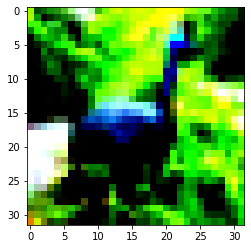

In [10]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


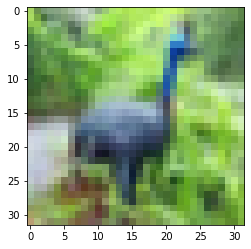

In [11]:
plt.imshow((img.permute(1, 2, 0)+2)/4)
plt.show()

In [12]:
img_batch = img.view(-1).unsqueeze(0)
display(img_batch.shape)

out = model(img_batch)
display(out)

_, index = torch.max(out, dim=1)
display(index)

torch.Size([1, 3072])

tensor([[0.3700, 0.6300]], grad_fn=<SoftmaxBackward>)

tensor([1])

## MSE Versus NLL

In [13]:
out = torch.tensor([
    [0.6, 0.4],
    [0.9, 0.1],
    [0.3, 0.7],
    [0.2, 0.8],
])
class_index = torch.tensor([0, 0, 1, 1]).unsqueeze(1)

truth = torch.zeros((4,2))
truth.scatter_(dim=1, index=class_index, value=1.0)
truth

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.]])

In [14]:
def mse(out, truth):
    return ((out - truth) ** 2).sum(dim=1).mean()

mse(out, truth)

tensor(0.1500)

In [15]:
out.gather(dim=1, index=class_index)

tensor([[0.6000],
        [0.9000],
        [0.7000],
        [0.8000]])

In [16]:
def likelihood(out, class_index):
    prod = 1.0
    for x in out.gather(dim=1, index=class_index):
        prod *= x
    return prod

likelihood(out, class_index)

tensor([0.3024])

In [17]:
def neg_log_likelihood(out, class_index):
    return -likelihood(out, class_index).log()

neg_log_likelihood(out, class_index)

tensor([1.1960])

In [18]:
out0 = out.clone().detach()
out0[0] = torch.tensor([0.9, 0.1]) # more right

out2 = out.clone().detach()
out2[0] = torch.tensor([0.4, 0.6]) # slightly wrong

out3 = out.clone().detach()
out3[0] = torch.tensor([0.1, 0.9]) # very wrong

In [19]:
mse_comparison = torch.tensor([mse(o, truth) for o in [out0, out, out2, out3]])
display(mse_comparison)

mse_diff = ((mse_comparison / mse_comparison[1]) - 1) * 100
display(mse_diff)

tensor([0.0750, 0.1500, 0.2500, 0.4750])

tensor([-50.0000,   0.0000,  66.6667, 216.6667])

In [20]:
nll_comparison = torch.tensor([neg_log_likelihood(o, class_index) 
                               for o in [out0, out, out2, out3]])
display(nll_comparison)

nll_diff = ((nll_comparison / nll_comparison[1]) - 1) * 100
display(nll_diff)

tensor([0.7905, 1.1960, 1.6015, 2.9878])

tensor([-33.9016,   0.0000,  33.9016, 149.8121])

## Softmax vs LogSoftmax

In [21]:
softmax = nn.Softmax(dim=1)
log_softmax = nn.LogSoftmax(dim=1)

x = torch.tensor([[0.0, 104.0]])
display(softmax(x))
display(log_softmax(x))

tensor([[0., 1.]])

tensor([[-104.,    0.]])

In [22]:
display(torch.log(softmax(x)))
display(log_softmax(x))

tensor([[-inf, 0.]])

tensor([[-104.,    0.]])

In [23]:
display(torch.exp(torch.log(softmax(x))))
display(torch.exp(log_softmax(x)))

tensor([[0., 1.]])

tensor([[0., 1.]])

## Use Torch.NN

In [24]:
torch.manual_seed(42)
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2),
            nn.LogSoftmax(dim=1))
loss = nn.NLLLoss()

img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.9561, grad_fn=<NllLossBackward>)

In [25]:
torch.manual_seed(42)
model = nn.Sequential(
            nn.Linear(3072, 512),
            nn.Tanh(),
            nn.Linear(512, 2))
loss = nn.CrossEntropyLoss()

img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.9561, grad_fn=<NllLossBackward>)